# Stakeholder

Apple as stakeholder and compare sentiment of its release vs. Google's at SXSW

# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import re

df = pd.read_csv('../data/tweets.csv', encoding = 'iso-8859-1')
sw = stopwords.words('english')

In [ ]:
#Gets rid of company column
tweets = df.drop('emotion_in_tweet_is_directed_at', axis = 1)

In [ ]:
tweets['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

In [ ]:
#Drops rows with unknown sentiment
tweets = tweets[tweets['is_there_an_emotion_directed_at_a_brand_or_product'] != 'I can\'t tell']

In [ ]:
#Renames column with sentiments as label and drops single nan row
tweets['label'] = tweets['is_there_an_emotion_directed_at_a_brand_or_product']
tweets = tweets.drop('is_there_an_emotion_directed_at_a_brand_or_product', axis = 1)
tweets = tweets.dropna()

In [ ]:
tweets.label.value_counts(normalize = True)

In [ ]:
#Reassigns label
tweets.label = tweets.label.map({'Negative emotion' : 0, 'Positive emotion': 1, 
                                 'No emotion toward brand or product': 2})

tweets.label.value_counts(normalize = True)

In [ ]:
#Functions to tokenize text
import string
from nltk.stem.snowball import SnowballStemmer

#Replaces pos tags with lemmatize compatable tags
def pos_replace(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
#Makes list of punctuation to exclude, keeps certain symbols
punct = list(string.punctuation)
keep_punct = ['#', '?', '!', '@']
punct = [p for p in punct if p not in keep_punct]

#Used to filter out words leftover by twitter scrape
common_tweet_words = ['rt']

#Removes non-ASCII characters (aka emojis that cant be converted to original symbol)
def remove_junk(tweet):
    return ''.join([i if ord(i) < 128 else ' ' for i in tweet])
    
#TRY LOWERING/NOT LEMMATIZING AND SEE WHAT CHANGES
def tweet_tokenizer(doc, stop_words = sw):
    #Gets rid of links
    doc = re.sub(r'http\S+', '', doc)
    doc = re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', '', doc)
    doc = re.sub(r'(?i)(#sxsw)\w*', '', doc)
    #Gets rid of conversions made during scrapping
    doc = re.sub(r'{link}', '', doc)
    doc = re.sub(r'\[video\]', '', doc)
    #Gets rid of weird characters
    doc = remove_junk(doc)
    #Tokenizes using NLTK Twitter Tokenizer
    tweet_token = TweetTokenizer(strip_handles = True)
    doc = tweet_token.tokenize(doc)
    #Gets rid of numbers
#     doc_2 = []
#     for w in doc:
#         if any([c.isdigit() for c in w]):
#             pass
#         else:
#             doc_2.append(w)
    #Gets rid of leftover stopwords/punctuation/twitter meta-info
    doc = [w for w in doc if w.lower() not in sw]
    doc = [w for w in doc if w.lower() not in common_tweet_words]
    doc = [w for w in doc if w not in punct]
    #Stemmer
#     snows = SnowballStemmer('english')
#     doc = [snows.stem(w) for w in doc]
    #Lemmatizes tokens
    doc = pos_tag(doc)
    doc = [(w[0], pos_replace(w[1])) for w in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    
    return doc

In [ ]:
t = tweets.loc[38, 'tweet_text']
test = tweet_tokenizer(t)
print(t)
print('\n')
print(test)

In [ ]:
test = 'Get rid of #sxsw #SXSW #Sxsw #SXSWedu don\'t delete this'
test = re.sub(r'(?i)(#sxsw)\w*', '', test)
test

# Visualizing Features with Graphs

In [ ]:
from matplotlib.ticker import MaxNLocator

def setup_three_subplots():
    """
    It's hard to make an odd number of graphs pretty with just nrows
    and ncols, so we make a custom grid. See example for more details:
    https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html

    We want the graphs to look like this:
     [ ] [ ] [ ]
       [ ] [ ]

    So we make a 2x6 grid with 5 graphs arranged on it. 3 in the
    top row, 2 in the second row

      0 1 2 3 4 5
    0|[|]|[|]|[|]|
    1| |[|]|[|]| |
    """
    fig = plt.figure(figsize=(15,9))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :2]) # row 0, cols 0-1
    ax2 = fig.add_subplot(gs[0, 2:4])# row 0, cols 2-3
    #ax3 = fig.add_subplot(gs[0, 4:]) # row 0, cols 4-5
    ax4 = fig.add_subplot(gs[1, 1:3])# row 1, cols 1-2
    #ax5 = fig.add_subplot(gs[1, 3:5])# row 1, cols 3-4
    return fig, [ax1, ax2, ax4]

def plot_distribution_of_column_by_category(column, axes, title="Word Frequency for"):
    for index, category in enumerate([0, 1, 2]):
        # Calculate frequency distribution for this subset
        all_words = tweets[tweets["label"] == index][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]

        # Set up plot
        ax = axes[index]
        ax.hist(tokens, counts)

        # Customize plot appearance
        ax.set_title(f"{title} {category}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=90)

# Data Exploration

In [ ]:
from nltk.probability import FreqDist

all_words = []
for tweet in tweets['tweet_text']:
    all_words.extend(tweet_tokenizer(tweet))


In [ ]:
words = set(all_words)
len(words)
print(words)

In [ ]:
fdist = FreqDist()
for word in all_words:
    fdist[word.lower()] += 1
    
fdist.plot(20, title = 'Frequency of Top 20 Words in Text')

# Feature Creation

In [ ]:
#Look for excessive puntuation - no go
def punc_count(tweet):
    punctuations = '!$%&()*+,-./:;<=>?[\]^_`{|}~'
    count = 0
    for p in punctuations:
        count += tweet.count(p)
    return count

#Look for excessive !/?'s' - no go
def exc_que_count(tweet):
    punctuation = '!?'
    count = 0
    for p in punctuation:
        count += tweet.count(p)
    return count

#only periods
def period_count(tweet):
    punctuation = '.'
    count = 0
    for p in punctuation:
        count += tweet.count(p)
    return count

#Ratio capital to length tweet
def capital_letter_ratio(tweet):
    capital_count = 0
    for c in tweet:
        if c.isupper():
            capital_count += 1
    return capital_count / len(tweet)

#Repeating words - fix to be adjacent
def any_repeats(tweet):
    if len(set(tweet.split())) < len(tweet.split()):
        return 1
    else:
        return 0 
    
#Hashtag count
def count_hash(tweet):
    hashtag = re.findall(r'(#w[A-Za-z0-9]*)', tweet)
    return len(hashtag)

#Average word length
def avg_length(tweet):
    char = len(tweet)
    word = len(tweet.split())
    return char / word

#Number of words
def word_count(tweet):
    return len(tweet.split())

#Add in if tweet about Apple or Google?
def what_company(tweet):
    tweet_check = tweet.lower()
    if ('iphone' in tweet_check) or ('ipad' in tweet_check) or ('apple' in tweet_check) or ('#apple' in tweet_check):
        if ('android' in tweet_check) or ('google' in tweet_check) or ('#google' in tweet_check):
            return 'Both'
        return 'Apple'
    if ('android' in tweet_check) or ('google' in tweet_check) or ('#google' in tweet_check):
        return 'Google'
    return 'Neither'

#Add in what service/product talk about?
def what_product(tweet):
    tweet_check = tweet.lower()
    if ('app' in tweet_check):
        return 'App'
    if ('iphone' in tweet_check) or ('phone' in tweet_check) or ('android' in tweet_check):
        return 'Phone'
    if ('ipad' in tweet_check):
        return 'iPad'
    if ('apple' in tweet_check):
        return 'Company'
    else:
        return 'General'
    
('google' in tweet_check) or 

In [ ]:
df.emotion_in_tweet_is_directed_at.value_counts()

In [ ]:
tweets['what_product'] = tweets['tweet_text'].apply(what_product)
tweets.what_product.value_counts()
# no_cat = tweets[tweets['what_product'] == 'General']
# for tweet in no_cat['tweet_text']:
#     print(tweet)

# Get rid of bad data

In [ ]:
tweets['word_count'] = tweets['tweet_text'].apply(word_count)
tweets['word_count'].describe()

In [ ]:
tweets[tweets['word_count'] == 2]

In [ ]:
tweets = tweets[tweets['word_count'] != 2]

In [ ]:
# negative = tweets[tweets.label == 0]
# tweet_tokenizer(negative['tweet_text'][291])

# Visualize Different Features

In [ ]:
tweets['punc_count'] = tweets['tweet_text'].apply(punc_count)

In [ ]:
#tweets.groupby('label')['exc_que_count'].value_counts()

In [ ]:
# fig, axes = setup_three_subplots()
# plot_distribution_of_column_by_category("punc_count", axes, "Freqency of Posts Containing Prices for")

# Test Each Feature With Logreg Cause Visuals Are Hard

In [ ]:
tweets_test = tweets.drop('tweet_text', axis = 1)

In [ ]:
#Train test split
y = tweets_test['label']
X = tweets_test.drop('label', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

X_train

In [ ]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

features = imbpipeline(steps=[
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(max_depth = 5, random_state = 213))
])

features.fit(X_train, y_train)
for name, importance in zip(X_train.columns, features['dtc'].feature_importances_):
    print(name, importance)

# Different Vectorizers

In [ ]:
#Train test split
y = tweets['label']
X = tweets.drop('label', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

col_labels = list(X_train.columns)
col_labels.remove('tweet_text')

### CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

#Vectorize the words
cv = CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)
X_train_cv = cv.fit_transform(X_train['tweet_text'])

#Scales the non-word columns
X_train_nowords = X_train[col_labels]
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_nowords),columns = X_train_nowords.columns, index = X_train.index)

#Combines the scaled and vectorized data together
X_train_cv_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names(), index = X_train.index)
X_train_final = pd.concat([X_train_cv_df, X_train_scaled], axis=1)

#SMOTE HERE

### TF_IDF Vec

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)
X_train_tfidf = tfidf.fit_transform(X_train['tweet_text'])

#Scales the non-word columns
X_train_nowords = X_train[col_labels]
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_nowords),columns = X_train_nowords.columns, index = X_train.index)

#Combines vectorized and scaled data together
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns = tfidf.get_feature_names(), index = X_train.index)
X_train_final = pd.concat([X_train_tfidf_df, X_train_scaled], axis=1)

#SMOTE HERE

# Models

### Multinomial Bayes - ONLY TEXT

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

#Train test split
y = tweets['label']
X = tweets['tweet_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

#Vectorize the words
cv = CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)
X_train_cv = cv.fit_transform(X_train)

#Fit and print model scores
first_pass = MultinomialNB()
first_pass.fit(X_train_cv, y_train)
print("Training Score:", first_pass.score(X_train_cv, y_train))
scores = np.mean(cross_val_score(first_pass, X_train_cv, y_train, cv=5))
print("Validation Score:" + str(scores))

### Other models - can add other features

# IGNORE/TESTING AREA

## IF WANT TRY PIPELINE/ADD FEATURE THINGY

In [ ]:
"""
from sklearn.pipeline import FeatureUnion, Pipeline
count_vec = FeatureUnion([
        ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer))
        #, add any feature creation things here
    ])

tfidf_vec = FeatureUnion([
        ('tfidf', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer))
        #, add any feature creation things here
    ])

first_pass = Pipeline(steps=[
    ('vec', count_vec),
    ('mnb', MultinomialNB())
])
"""

In [ ]:
def punc_count(tweet):
    punctuations = '!$%&()*+,-./:;<=>?[\]^_`{|}~'
    count = 0
    for p in punctuations:
        count += tweet.count(p)
    return count

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class PuncCount(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return pd.Series(X).apply(punc_count)

In [ ]:
y = tweets['label']
X = tweets['tweet_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

In [ ]:
from sklearn.pipeline import FeatureUnion, Pipeline

count_vec = FeatureUnion([
        ('punc', PuncCount()),
        ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer))
    ])

first_pass = Pipeline(steps=[
    ('preproc', count_vec),
    #('ss', StandardSclaer()) - only if added features on diff scale
    ('mnb', MultinomialNB())
])

first_pass.fit(X_train, y_train)
print("Training Score:", first_pass.score(X_train, y_train))
scores = np.mean(cross_val_score(first_pass, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

In [ ]:
pc = PuncCount()
pc.fit(X_train)
test = pc.transform(X_train)
test

# Baseline Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

y = tweets['label']
X = tweets['tweet_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

baseline = imbpipeline(steps=[
    ('preproc', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213, max_depth = 5))
])

baseline.fit(X_train, y_train)
print("Training Score:", baseline.score(X_train, y_train))
scores = np.mean(cross_val_score(baseline, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

# Iterating Models

In [ ]:
#Making final dataset
tweets['capital_letter_ratio'] = tweets['tweet_text'].apply(capital_letter_ratio)
tweets['exc_que_count'] = tweets['tweet_text'].apply(exc_que_count)
tweets['what_company'] = tweets['tweet_text'].apply(what_company)
tweets['what_product'] = tweets['tweet_text'].apply(what_product)
tweets = tweets.drop('word_count', axis = 1)
tweets.head()

In [ ]:
#Train test split
y = tweets['label']
X = tweets.drop('label', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

col_labels = list(X_train.columns)
col_labels.remove('tweet_text')

### MNB - No Tuning

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = True, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_company', 'what_product'])],
    #('scale', MinMaxScaler(), col_labels)],
    remainder = 'passthrough')

first = imbpipeline(steps=[
    ('preproc', count_vec),
    ('mnb', MultinomialNB())
])

first.fit(X_train, y_train)
print("Training Score:", first.score(X_train, y_train))
scores = np.mean(cross_val_score(first, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

count_vec = ColumnTransformer([
    ('cv', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = True, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_company', 'what_product'])],
    #('scale', MinMaxScaler(), col_labels)],
    remainder = 'passthrough')

first = imbpipeline(steps=[
    ('preproc', count_vec),
    #('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('mnb', MultinomialNB())
])

first.fit(X_train, y_train)
print("Training Score:", first.score(X_train, y_train))
scores = np.mean(cross_val_score(first, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))


In [ ]:
from sklearn.model_selection import GridSearchCV

#Creates parameters to test
params = {
    'preproc__cv__min_df': [1, .1, 0],
    'preproc__cv__max_df': [.8, .9, 0],
    'preproc__cv__ngram_range': [(1,1), (1,2), (2,2)]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(first, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

count_vec = ColumnTransformer([
    ('cv', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = True, tokenizer = tweet_tokenizer,
                          min_df = 1, max_features = 8000, ngram_range = (1,2)), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_company', 'what_product'])],
    #('scale', MinMaxScaler(), col_labels)],
    remainder = 'passthrough')

first = imbpipeline(steps=[
    ('preproc', count_vec),
    #('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('mnb', MultinomialNB())
])

first.fit(X_train, y_train)
print("Training Score:", first.score(X_train, y_train))
scores = np.mean(cross_val_score(first, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))


### Logistic Regression - No Tuning

In [ ]:
from sklearn.linear_model import LogisticRegression

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

second = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('logreg', LogisticRegression(random_state = 213, max_iter = 1000))
])

second.fit(X_train, y_train)
print("Training Score:", second.score(X_train, y_train))
scores = np.mean(cross_val_score(second, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

### Logreg - gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV

#Creates parameters to test
params = {
    'logreg__C': [1.0, 1e3, 1e6],
    'logreg__solver': ['lbfgs', 'saga']
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(second, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

### This would be where our tuned logreg went - if we had one

In [ ]:
# Unknown tuned (?) model

### MNB - Gridsearch (lowercase/min max)

In [ ]:
#Creates parameters to test
params = {
    'preproc__cv__lowercase': [True, False],
    'preproc__cv__min_df': [0, .05, .1],
    'preproc__cv__max_df': [1, .95, .9]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(first, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
#Tuned MNB
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          max_df = .95), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

tuned_mnb = imbpipeline(steps=[
    ('preproc', count_vec),
    ('mnb', MultinomialNB())
])

tuned_mnb.fit(X_train, y_train)
print("Training Score:", tuned_mnb.score(X_train, y_train))
scores = np.mean(cross_val_score(tuned_mnb, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

### MNB - gridsearch (ngram)

In [ ]:
from sklearn.model_selection import GridSearchCV

#Creates parameters to test
params = {
    'preproc__cv__ngram_range': [(1,1), (1,2), (2,2)]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(tuned_mnb, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          max_df = .95, ngram_range = (1,2)), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

ngram = imbpipeline(steps=[
    ('preproc', count_vec),
    ('mnb', MultinomialNB())
])

ngram.fit(X_train, y_train)
print("Training Score:", ngram.score(X_train, y_train))
scores = np.mean(cross_val_score(ngram, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

### MNB - gridsearch ngram max features

In [ ]:
from sklearn.model_selection import GridSearchCV

#Creates parameters to test
params = {
    'preproc__cv__max_features': [None, 4000, 8000],
    'preproc__cv__max_df': [.3, .5, .8],
    'preproc__cv__ngram_range': [(1,1), (1,2), (2,2)]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(ngram, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          ngram_range = (1,1), max_df = .7, max_features = 8000), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

test = imbpipeline(steps=[
    ('preproc', count_vec),
    ('mnb', MultinomialNB())
])

test.fit(X_train, y_train)
print("Training Score:", test.score(X_train, y_train))
scores = np.mean(cross_val_score(test, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

### Decision Tree - Tuning

In [ ]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

tree = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213))
])

tree.fit(X_train, y_train)
print("Training Score:", tree.score(X_train, y_train))
scores = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

In [ ]:
#Creates parameters to test
params = {
    'dtc__max_depth': [10, 20, 30],
    'dtc__min_samples_split': [2, 5, 10]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(tree, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
#min sample split = 5/max_depth = 20 has less overfitting
tree = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213, min_samples_split = 2, max_depth = 30))
])

tree.fit(X_train, y_train)
print("Training Score:", tree.score(X_train, y_train))
scores = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

## DTC w/ bigrams

In [ ]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          ngram_range = (1,2)), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

dtc_test = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213))
])

dtc_test.fit(X_train, y_train)
print("Training Score:", dtc_test.score(X_train, y_train))
scores = np.mean(cross_val_score(dtc_test, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

In [ ]:
#Creates parameters to test
params = {
    'dtc__max_depth': [20, 30, 40],
    'dtc__criterion': ['entropy', 'gini']
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(dtc_test, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          ngram_range = (1,2)), 'tweet_text')],
    #('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

dtc_test = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213, max_depth = 30, max_features = 3000))
])

dtc_test.fit(X_train, y_train)
print("Training Score:", dtc_test.score(X_train, y_train))
scores = np.mean(cross_val_score(dtc_test, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

## Logreg with bigram

In [ ]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          ngram_range = (1,2), max_features = 1500), 'tweet_text'),
    ('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

logreg_worse = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state = 213)),
    ('logreg', LogisticRegression(random_state = 213, max_iter = 1000))
])

logreg_worse.fit(X_train, y_train)
print("Training Score:", logreg_worse.score(X_train, y_train))
scores = np.mean(cross_val_score(logreg_worse, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

In [ ]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                          ngram_range = (1,2)), 'tweet_text'),
    ('scale', StandardScaler(), col_labels)],
    remainder = 'passthrough')

logreg_bi = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state = 213)),
    ('logreg', LogisticRegression(random_state = 213, max_iter = 1000))
])

logreg_bi.fit(X_train, y_train)
print("Training Score:", logreg_bi.score(X_train, y_train))
scores = np.mean(cross_val_score(logreg_bi, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

In [ ]:
#Creates parameters to test
params = {
    'preproc__cv__ngram_range': [(1,1), (1,2), (2,2)],
    'preproc__cv__max_features': [None, 1000, 2000]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(logreg_bi, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

# Word2Vec

In [ ]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
            
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
from gensim.models import word2vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

all_words = []
for tweet in tweets['tweet_text']:
    all_words.extend(tweet_tokenizer(tweet))
    

vocab_mix = set(all_words)
test = []
for word in vocab_mix:
    test.append(word.lower())
vocab = set(test)

glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

y = tweets['label']
X = tweets['tweet_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#Pick a Pipeline to try
w2v_rfc = Pipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('rf', RandomForestClassifier(random_state = 42))
])

w2v_svc = Pipeline([
    ('Word2Vec Vectorizer', W2vVectorizer(glove)),
    ('Support Vector Machine', SVC())
])

w2v_logreg = Pipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('lr', LogisticRegression(max_iter = 1000, random_state = 42))
])

models = [('Random Forest', w2v_rfc),
          ('Support Vector Machine', w2v_svc),
          ('Logistic Regression', w2v_logreg)]

scores = [(name, cross_val_score(model, X_train, y_train, cv = 3).mean()) for name, model, in models]
scores

In [ ]:
#Creates parameters to test
params = {
    'rf__n_estimators': [100, 300, 500],
    'rf__min_samples_split': [2, 5, 10]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(w2v_rfc, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
w2v_tuned = Pipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('rf', RandomForestClassifier(n_estimators = 300, random_state = 42))
])

w2v_tuned.fit(X_train, y_train)
print("Training Score:", w2v_tuned.score(X_train, y_train))
scores = np.mean(cross_val_score(w2v_tuned, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

# Word2Vec with SMOTE

In [ ]:
w2v_rfc = imbpipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('rf', RandomForestClassifier(random_state = 42))
])

w2v_svc = imbpipeline([
    ('Word2Vec Vectorizer', W2vVectorizer(glove)),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('Support Vector Machine', SVC())
])

w2v_logreg = imbpipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('lr', LogisticRegression(max_iter = 1000, random_state = 42))
])

models = [('Random Forest', w2v_rfc),
          ('Support Vector Machine', w2v_svc),
          ('Logistic Regression', w2v_logreg)]

scores = [(name, cross_val_score(model, X_train, y_train, cv = 3).mean()) for name, model, in models]
scores

In [ ]:
#Creates parameters to test
params = {
    'rf__n_estimators': [500, 800, 1000],
    'rf__min_samples_split': [2, 5, 10]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(w2v_rfc, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
w2v_tuned = Pipeline([
    ('Word2Vec', W2vVectorizer(glove)),
    ('rf', RandomForestClassifier(n_estimators = 800, min_samples_split = 2, random_state = 42))
])

w2v_tuned.fit(X_train, y_train)
print("Training Score:", w2v_tuned.score(X_train, y_train))
scores = np.mean(cross_val_score(w2v_tuned, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

# Getting only Apple Tweets

In [2]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [3]:
no_labels = df[df['emotion_in_tweet_is_directed_at'].isna()]
no_labels = no_labels.dropna(subset = ['tweet_text'])

In [4]:
tweet_list = []
for tweet in no_labels['tweet_text']:
    tweet_check = tweet.lower()
    if ('iphone' in tweet_check) or ('ipad' in tweet_check) or ('apple' in tweet_check):
        tweet_list.append(tweet)

In [5]:
ipad = df[df['emotion_in_tweet_is_directed_at'] == 'iPad']
apple = df[df['emotion_in_tweet_is_directed_at'] == 'Apple']
mix = df[df['emotion_in_tweet_is_directed_at'] == 'iPad or iPhone App']
iphone = df[df['emotion_in_tweet_is_directed_at'] == 'iPhone']
apps = df[df['emotion_in_tweet_is_directed_at'] == 'Other Apple product or service']

unlabeled_apple = df[df['tweet_text'].isin(tweet_list)]
unlabeled_apple = unlabeled_apple.drop_duplicates(subset = 'tweet_text')

final_df = pd.concat([ipad, apple, mix, iphone, apps, unlabeled_apple], axis = 0)

final_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
20,Need to buy an iPad2 while I'm in Austin at #s...,iPad,Positive emotion
25,RT @LaurieShook: I'm looking forward to the #S...,iPad,Positive emotion
36,The best! RT @mention Ha! First in line for #...,iPad,Positive emotion
57,{link} RT @mention 1st stop on the #SXSW #Chao...,iPad,Positive emotion


In [6]:
final_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize = True)

No emotion toward brand or product    0.519993
Positive emotion                      0.386466
Negative emotion                      0.075629
I can't tell                          0.017912
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [7]:
tweets = final_df.drop('emotion_in_tweet_is_directed_at', axis = 1)
tweets = tweets[tweets['is_there_an_emotion_directed_at_a_brand_or_product'] != 'I can\'t tell']
tweets['label'] = tweets['is_there_an_emotion_directed_at_a_brand_or_product']
tweets = tweets.drop('is_there_an_emotion_directed_at_a_brand_or_product', axis = 1)
tweets = tweets.dropna()
tweets.label = tweets.label.map({'Negative emotion' : 0, 'Positive emotion': 1, 
                                 'No emotion toward brand or product': 2})

tweets.label.value_counts(normalize = True)

2    0.529477
1    0.393515
0    0.077008
Name: label, dtype: float64

In [132]:
retweets = tweets.copy()
retweets['tweet_text'] = retweets['tweet_text'].str.lower()
retweets['tweet_text'].value_counts()
retweets.head(5)

,tweet_text,label
2,@swonderlin can not wait for #ipad 2 also. the...,1
20,need to buy an ipad2 while i'm in austin at #s...,1
25,rt @laurieshook: i'm looking forward to the #s...,1
36,the best! rt @mention ha! first in line for #...,1
57,{link} rt @mention 1st stop on the #sxsw #chao...,1


In [133]:
# This is making a new column indicating if a line is a retweet or not
# tweets are scanned for "rt" to identify them as retweets

counter=0
retweet_list = []

for i in retweets['tweet_text']:
    rt = False
    if i.startswith('rt ') or ' rt ' in i or (i.endswith(' rt')):
        rt = True
    for pos in [' rt.',' rt, ']:
        if pos in i:
            rt = True
    if rt:
        retweet_list.append(1)
        counter += 1
    else:
        retweet_list.append(0)

retweets['retweet'] = retweet_list
print(counter)
retweets['retweet'].value_counts()

1489


0    3939
1    1489
Name: retweet, dtype: int64

In [134]:
single_tweets_ct = len([0 for i in retweets['retweet'] if i == 0])
retweets_ct = len([1 for i in retweets['retweet'] if i == 1])

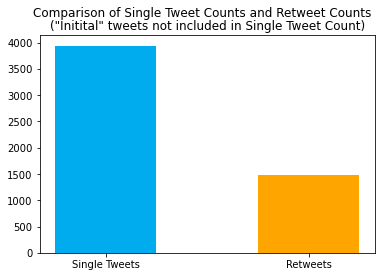

In [167]:
retweets_ratio = retweets_ct / (retweets_ct + single_tweets_ct)
tweets_ratio_plot = [single_tweets_ct, retweets_ct]
x_labels = ['Single Tweets', 'Retweets']
plt.bar(x=x_labels, height=tweets_ratio_plot, width = 0.5, color=['#00ACEE','orange'])
plt.suptitle('Comparison of Single Tweet Counts and Retweet Counts')
plt.title('("Initital" tweets not included in Single Tweet Count)');

In [88]:
retweets.head()

,tweet_text,label,retweet
2,@swonderlin can not wait for #ipad 2 also. the...,1,0
20,need to buy an ipad2 while i'm in austin at #s...,1,0
25,rt @laurieshook: i'm looking forward to the #s...,1,1
36,the best! rt @mention ha! first in line for #...,1,1
57,{link} rt @mention 1st stop on the #sxsw #chao...,1,1


In [89]:
retweets['label'].value_counts()

2    2874
1    2136
0     418
Name: label, dtype: int64

# Apple Baseline Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

y = tweets['label']
X = tweets['tweet_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

baseline = imbpipeline(steps=[
    ('preproc', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213, max_depth = 5))
])

baseline.fit(X_train, y_train)
print("Training Score:", baseline.score(X_train, y_train))
scores = np.mean(cross_val_score(baseline, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

# Multinomial Model

In [ ]:
#Making final dataset
tweets['capital_letter_ratio'] = tweets['tweet_text'].apply(capital_letter_ratio)
tweets['exc_que_count'] = tweets['tweet_text'].apply(exc_que_count)
tweets['what_product'] = tweets['tweet_text'].apply(what_product)
#tweets = tweets.drop('word_count', axis = 1)
tweets.head()

In [ ]:
#Train test split
y = tweets['label']
X = tweets.drop('label', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

col_labels = list(X_train.columns)
col_labels.remove('tweet_text')

In [ ]:
X_train

### MNB w/ cv

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = True, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_product'])],
    #('scale', MinMaxScaler(), col_labels)],
    remainder = 'passthrough')

apple_cv = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('mnb', MultinomialNB())
])

apple_cv.fit(X_train, y_train)
print("Training Score:", apple_cv.score(X_train, y_train))
scores = np.mean(cross_val_score(apple_cv, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))



### MNB w/ TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

count_vec = ColumnTransformer([
    ('tfidf', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_product'])],
    #('scale', MinMaxScaler(), col_labels)],
    remainder = 'passthrough')

apple = imbpipeline(steps=[
    ('preproc', count_vec),
    #('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('mnb', MultinomialNB())
])

apple.fit(X_train, y_train)
print("Training Score:", apple.score(X_train, y_train))
scores = np.mean(cross_val_score(apple, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))



### MNB GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

#Creates parameters to test
params = {
    'preproc__tfidf__max_features': [None, 4000, 8000, 10000],
    'preproc__tfidf__max_df': [.4, .6, .8],
    'preproc__tfidf__ngram_range': [(1,1), (1,2), (2,2)]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(apple, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

count_vec = ColumnTransformer([
    ('tfidf', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_product'])],
    #('scale', MinMaxScaler(), col_labels)],
    remainder = 'passthrough')

apple_tuned = imbpipeline(steps=[
    ('preproc', count_vec),
    #('smote', SMOTE(sampling_strategy = 'not majority', random_state=11)),
    ('mnb', MultinomialNB())
])

apple_tuned.fit(X_train, y_train)
print("Training Score:", apple_tuned.score(X_train, y_train))
scores = np.mean(cross_val_score(apple_tuned, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))


### Decision Tree Tuning

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

count_vec = ColumnTransformer([
    ('cv', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_product'])],
    #('scale', MinMaxScaler(), col_labels)],
    remainder = 'passthrough')

apple_dt = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213))
])

apple_dt.fit(X_train, y_train)
print("Training Score:", apple_dt.score(X_train, y_train))
scores = np.mean(cross_val_score(apple_dt, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))


In [ ]:
from sklearn.model_selection import GridSearchCV

#Creates parameters to test
params = {
    'dtc__max_depth': [None, 5, 20],
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__min_samples_split': [2, 5, 10]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(apple_dt, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

count_vec = ColumnTransformer([
    ('cv', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_product'])],
    #('scale', MinMaxScaler(), col_labels)],
    remainder = 'passthrough')

apple_dt = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state=11)),
    ('dtc', DecisionTreeClassifier(min_samples_split = 5, random_state = 213))
])

apple_dt.fit(X_train, y_train)
print("Training Score:", apple_dt.score(X_train, y_train))
scores = np.mean(cross_val_score(apple_dt, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

